In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import dateutil.parser
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

In [8]:
USAGE = '201906_Usage_Bicimad.json'

#  Limpieza de datos

In [9]:
usage_df = pd.read_json(USAGE, lines=True)

In [10]:
usage_df['unplug_hourTime'] = json_normalize(usage_df['unplug_hourTime'])

Transformamos en día y hora la fecha en que se coge cada bicicleta:

In [11]:
import datetime
usage_df['unplug_hourTime'] = pd.to_datetime(usage_df['unplug_hourTime']).dt.strftime("%m-%d-%Y, %H:%M:%S")

In [12]:
new = usage_df["unplug_hourTime"].str.split(", ", n = 1, expand = True) 

In [13]:
usage_df['unplug_date'] = new[0]
usage_df['unplug_hour'] = new[1]

In [14]:
usage_df.drop(columns =["unplug_hourTime"], inplace = True) 

In [9]:
# Qué es esto

def make_int(s):
    s = s.strip()
    if s.isdigit() and len(s) <= 8:
        return int(s)
    else: return 0

In [10]:
usage_df['zip_code'] = usage_df['zip_code'].apply(lambda x: make_int(x))

In [15]:
usage_df = usage_df.drop(['_id', 'user_day_code', 'idplug_base', 'idunplug_base', 'track'], axis = 1)

In [12]:
#hay usuarios con zip code == 0 (ruido, eliminamos también esta feature)
usage_df[usage_df['zip_code'] == 0].count()

user_type           221839
travel_time         221839
idunplug_station    221839
ageRange            221839
idplug_station      221839
zip_code            221839
unplug_date         221839
unplug_hour         221839
dtype: int64

In [13]:
usage_df['zip_code'].count()

450811

In [16]:
usage_df = usage_df.drop('zip_code', axis = 1)

In [17]:
usage_df.head()

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_date,unplug_hour
0,1,219,90,0,66,06-01-2019,00:00:00
1,1,359,71,4,136,06-01-2019,00:00:00
2,1,375,39,4,38,06-01-2019,00:00:00
3,1,264,66,5,90,06-01-2019,00:00:00
4,1,367,152,4,166,06-01-2019,00:00:00


In [18]:
usage_df.shape

(450811, 7)

# Análisis de datos

La columna travel_time esta en segundos, por lo que la pasamos a minutos para poder analizar los tiempos mejor. La media de tiempo de uso es de 17,24 minutos pero la desviacion estandar es bastante alta, ¿por qué?, en este caso el tiempo minimo es de 7 min y el max 11004 minutos 7 dias?, podria ser que se perdió? o se puede tener una bici 7 dias? 

In [19]:
usage_df['travel_time'] = usage_df['travel_time']/60
usage_df.head(5)

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_date,unplug_hour
0,1,3.650000,90,0,66,06-01-2019,00:00:00
1,1,5.983333,71,4,136,06-01-2019,00:00:00
2,1,6.250000,39,4,38,06-01-2019,00:00:00
3,1,4.400000,66,5,90,06-01-2019,00:00:00
4,1,6.116667,152,4,166,06-01-2019,00:00:00


In [20]:
usage_df['travel_time'].describe()

count    450811.000000
mean         17.240246
std          59.668311
min           0.000000
25%           7.833333
50%          11.716667
75%          17.533333
max       11004.283333
Name: travel_time, dtype: float64

In [19]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

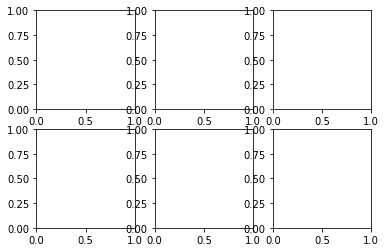

In [20]:
fig, axs = plt.subplots(2, 3)

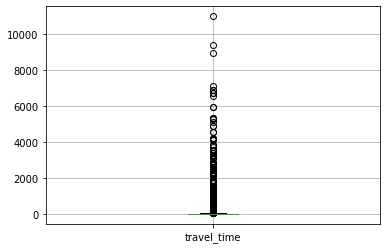

In [21]:
df_non_extreme_travel_times = usage_df.loc[usage_df['travel_time'] > 0]
df_non_extreme_travel_times.boxplot(column='travel_time')

In [22]:
usage_df.loc[usage_df['travel_time'] > 6000].count()

user_type           9
travel_time         9
idunplug_station    9
ageRange            9
idplug_station      9
unplug_date         9
unplug_hour         9
dtype: int64

In [21]:
time_list = usage_df['unplug_hour'].value_counts()
time_counts = pd.DataFrame(time_list)
time_counts.sort_index(inplace=True)
time_counts

,unplug_hour
00:00:00,13731
01:00:00,10012
02:00:00,7097
03:00:00,4343
04:00:00,3141
05:00:00,2321
06:00:00,3796
07:00:00,12704
08:00:00,27859
09:00:00,25339


**Uso de bicis por hora**

- Vemos que la hora punta son las 19:00, y la de menos ocupación las 05:00

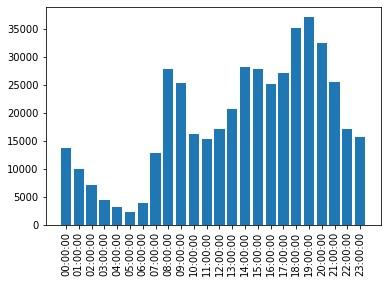

In [22]:
# Make a fake dataset:
time = time_counts['unplug_hour']
bars = time_counts.index
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, time)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90)

# Show graphic
plt.show()

In [25]:
usage_df['unplug_hour'].describe()

count       450811
unique          24
top       19:00:00
freq         37008
Name: unplug_hour, dtype: object

Porcentaje según el **tipo de usuario**
- 1: usuario anual
- 2: usuario ocasional
- 3: trabajador de la empresa

In [26]:
round(((pd.crosstab(index=usage_df["user_type"],  
                      columns="count").sort_values(by='count', ascending=False))/usage_df.user_type.count())*100, 2)

col_0,count
user_type,
1,92.89
3,5.84
2,1.27


In [56]:
file = pd.DataFrame(usage_df.groupby(['user_type'])['travel_time'].mean())
file.head()

,travel_time
user_type,
1,14.999532
2,41.094281
3,47.697213


#### Analisis de trayectos (estaciones de desenganche y enganche)

In [27]:
usage_df['idunplug_station'].unique()

array([  90,   71,   39,   66,  152,   55,  133,  153,   44,   85,   31,
         38,  118,   27,  100,   67,   63,   42,   77,   78,   99,  114,
        156,  165,  130,   83,  174,   25,   15,   76,  116,  169,   19,
        167,   56,   48,  163,   20,  150,   36,  154,   86,  102,  107,
        170,  166,  104,    8,   80,  122,   52,   51,   16,  135,  151,
        103,   10,   26,  157,   12,  123,    1,   46,   13,  124,   62,
         59,   65,  168,   57,    2,  132,  145,   50,   74,  126,   75,
        115,    5,    3,  106,  149,   93,   30,   41,  111,   87,   33,
        129,   60,  125,  136,  139,   54,   40,   84,  138,  128,   69,
         82,  155,   49,  109,   21,   96,   94,  134,   45,   58,    9,
        161,   64,  117,  141,   18,  173,   98,  190,    4,  171,  113,
         91,  127,    6,  144,  147,  159,  131,   47,    7,  158,  211,
        143,   28,   88,   72,  110,  137,   95,  164,  142,  120,   53,
         14,  148,   17,  162,  160,  172,   73,   

In [28]:
count_series = usage_df.groupby(['idunplug_station', 'idplug_station']).size()
count_series

idunplug_station  idplug_station
1                 1                 88
                  2                 11
                  3                  7
                  4                  3
                  5                  9
                                    ..
213               184                1
                  200                1
                  207                5
                  213               44
2008              2008               6
Length: 29102, dtype: int64

In [29]:
new_df = count_series.to_frame(name = 'size').reset_index()
new_df

,idunplug_station,idplug_station,size
0,1,1,88
1,1,2,11
2,1,3,7
3,1,4,3
4,1,5,9
...,...,...,...
29097,213,184,1
29098,213,200,1
29099,213,207,5
29100,213,213,44


En las estaciones que se engancha y desenganchan bicis podemos ver que se repite mucho que se engancha y desengancha en la misma estacion. ¿por qué? 

buscando en usage_df los valores con mas viajes, podemos ver en el box_plot que la mayoria son de una duracion entre 0 - 50 min, los viajes de menos de un min podrian ser por algun tipo de equivocación y los demás podria ser de usuarios frecuentes quizas?  

In [60]:
new_df.sort_values(by=['size'], ascending=False)[:5]

,idunplug_station,idplug_station,size
21221,135,135,363
863,6,6,355
9873,64,64,331
1528,9,149,313
27766,175,175,298


In [24]:
stations_travel = usage_df[['idunplug_station','idplug_station', 'travel_time', 'user_type']].loc[(usage_df.idunplug_station == 135) & (usage_df.idplug_station == 135)]

In [25]:
stations_travel.loc[stations_travel.travel_time < 1].count()

idunplug_station    101
idplug_station      101
travel_time         101
user_type           101
dtype: int64

In [26]:
stations_travel.loc[stations_travel.travel_time < 1].mean()

idunplug_station    135.000000
idplug_station      135.000000
travel_time           0.213366
user_type             3.000000
dtype: float64

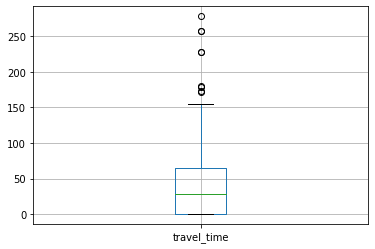

In [27]:
stations_travel.boxplot(column='travel_time')

Podemos ver que los viajes mas frecuentes son hechos por los abonados(algo obvio). Pero para los que son de menos de 5 min, la gran mayoria son de usuarios del tipo 3(empleados) por lo que podria ser por algun tipo de mantenimiento. 


De todo este analisis podriamos sacar que los viajes mas frecuentes podrian ser para realizar tareas diarias como ir al super o cuestiones parecidades ya que son usuarios que cogen las bicis y las dejan en la misma estación y la media no pasa de 50 min. 

In [118]:
stations_travel.loc[(stations_travel.travel_time > 10)].groupby(['user_type', 'travel_time']).count()

idunplug_station  idplug_station
user_type travel_time                                  
1         11.033333                   1               1
          11.116667                   1               1
          11.600000                   1               1
          11.916667                   1               1
          12.616667                   1               1
...                                 ...             ...
2         79.066667                   2               2
          90.666667                   1               1
          92.833333                   2               2
          107.950000                  1               1
3         178.983333                  1               1

[183 rows x 2 columns]

In [122]:
stations_travel.loc[(stations_travel.travel_time < 5)].groupby(['user_type', 'travel_time']).count()

idunplug_station  idplug_station
user_type travel_time                                  
3         0.033333                    7               7
          0.050000                    5               5
          0.066667                    3               3
          0.083333                   11              11
          0.100000                    2               2
          0.116667                   10              10
          0.133333                   14              14
          0.150000                    9               9
          0.166667                    3               3
          0.183333                    5               5
          0.200000                    2               2
          0.216667                    1               1
          0.233333                    2               2
          0.250000                    6               6
          0.266667                    1               1
          0.283333                    4               4
          0.300000                    2               2
          0.333333                    2               2
          0.383333                    1               1
          0.600000                    3               3
          0.650000                    2               2
          0.833333                    3               3
          0.850000                    1               1
          0.883333                    1               1
          0.983333                    1               1
          1.466667                    1               1
          1.850000                    2               2
          2.433333                    1               1
          3.800000                    1               1
          4.416667                    1               1

In [28]:
usage_df.corr()

,user_type,travel_time,idunplug_station,ageRange,idplug_station
user_type,1.000000,0.135024,0.059032,0.008933,0.049995
travel_time,0.135024,1.000000,0.012026,-0.020478,0.017147
idunplug_station,0.059032,0.012026,1.000000,-0.007310,0.104587
ageRange,0.008933,-0.020478,-0.007310,1.000000,-0.011310
idplug_station,0.049995,0.017147,0.104587,-0.011310,1.000000


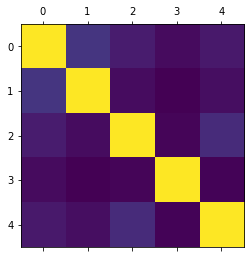

In [29]:
plt.matshow(usage_df.corr())